In [207]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import os
from os.path import basename, splitext
from utils.utils import PatternRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')

from utils.psi import *
from utils.age import *

In [3]:
#human GRCh37/hg19 source=(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3695075/)

p = '/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/data_joined.csv'
dfa = pd.read_csv(p, index_col=0)
meta = pd.read_csv('/home/shappiron/Desktop/Bio/Antiaging/Dynamics of aging/data/GSE87571/descriptions_samples.csv', 
                   index_col=0)
dfa = dfa[meta.index]
print('Age, N sites', len(dfa.index))

Age, N sites 450203


In [4]:
#corr block
#reprogramming data GRCh37/hg19 source=(https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1413299111&file=pnas.201413299SI.pdf)
dfr = pd.read_csv('./data/GSE54848/data.csv', index_col=0)
metr = pd.read_csv('data/GSE54848/GSE54848_metadata.csv', index_col=0).loc[dfr.columns]
mapper = dict(zip(metr.title.apply(lambda x: x.split('_')[0]).unique(), 
                  [0, 3, 7, 11, 15, 20 ,28, 35, 42, 49, 50, 50]))
metr['age'] = metr.title.apply(lambda x: x.split('_')[0]).map(mapper)
print('Rep, N sites', len(dfr.index))

Rep, N sites 485577


In [5]:
#common_sites
common_sites = dfa.index.intersection(dfr.index)

dfa = dfa.loc[common_sites]
dfr = dfr.loc[common_sites]

# Check if different aging clocks predict rejuvenation

In [6]:
#get clocks
#read all clock models
paths = glob('methylclock/data/*.rda')
stoplist = ['coefLeeGA', 'coefTL']
clocks = {}
for p in paths:
    name = splitext(basename(p))[0]
    if name in stoplist:
        continue
    if not(name.__contains__('coef')):
        continue
    rda = pyreadr.read_r(p) # also works for Rds, rda
    clocks[name] = rda[name].set_index('CpGmarker')

In [7]:
#predict aging
model_predictions = {}
for name, clock in tqdm(clocks.items()):
    sites = clock.index.intersection(dfa.index)
    if len(sites) > 50000:
        continue
    ages = []
    means = []
    for s in dfa.columns:
        row = dfa.loc[sites, s]
        avg = row.mean()
        w = clock.loc[sites, 'CoefficientTraining']
        age = (row * w).sum()
        if '(Intercept)' in clock.index:
            age += clock.loc['(Intercept)', 'CoefficientTraining']
        ages.append(age)   
        means.append(avg)  

    #scaling       
    ages = np.array(ages)
    ages = (ages - ages.min()) 
    ages = ages / ages.max() * 60

    meta['eAge' + f'_{name}'] = ages
    meta['averages'] = means
    model_predictions[name] = ages
groupa = meta.groupby('age').mean().filter(regex='eAge')

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_29330/247942222.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupa = meta.groupby('age').mean().filter(regex='eAge')


In [8]:
#predict reprogramming
model_predictions = {}
for name, clock in tqdm(clocks.items()):
    sites = clock.index.intersection(dfr.index)
    if len(sites) > 50000:
        continue
    ages = []
    means = []
    for s in dfr.columns:
        row = dfr.loc[sites, s]
        avg = row.mean()
        w = clock.loc[sites, 'CoefficientTraining']
        age = (row * w).sum()
        if '(Intercept)' in clock.index:
            age += clock.loc['(Intercept)', 'CoefficientTraining']
        ages.append(age)   
        means.append(avg)  

    #scaling       
    ages = np.array(ages)
    ages = (ages - ages.min()) 
    ages = ages / ages.max() * 60

    metr['eAge' + f'_{name}'] = ages
    metr['averages'] = means
    model_predictions[name] = ages
groupr = metr.groupby('age').mean().filter(regex='eAge')

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_29330/2423959328.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupr = metr.groupby('age').mean().filter(regex='eAge')


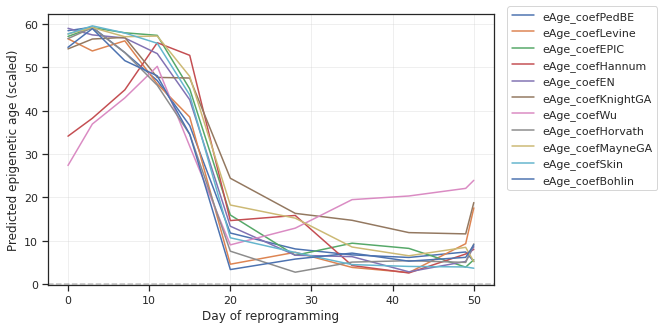

In [9]:
xplot = groupr.index

fig, axes = plt.subplots(1, 1, figsize=(8,5))
for c in groupr.columns:
    axes.plot(xplot, groupr[c], label=c)
axes.legend(loc=[1.03, 0.35])
axes.grid(alpha=0.3)
axes.axhline(0, ls='--', alpha=0.5, color='grey')
axes.set_xlabel('Day of reprogramming')
axes.set_ylabel('Predicted epigenetic age (scaled)')
plt.show()

# Check Dataset shift

In [105]:
cname = 'coefHannum'
clock = clocks[cname]
sites = clock.index.intersection(dfr.index)

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

y = meta['age']

Xa_clock = Xa_clock #- Xa_clock.mean(0)
Xr_clock = Xr_clock #- Xr_clock.mean(0)

# X_train, X_test, y_train, y_test = train_test_split(Xa_clock, y, test_size=0.25, random_state=10)

In [106]:
pca = PCA(2)
# Xpa = pca.fit_transform(Xa_clock)
# Xpr = pca.transform(Xr_clock)
pca.fit(Xa_clock.append(Xr_clock))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

ya = meta[f'eAge_{cname}']
yr = metr[f'eAge_{cname}']

pvar = np.round(pca.explained_variance_ratio_, 2)
pvar

/tmp/ipykernel_29330/2579722739.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca.fit(Xa_clock.append(Xr_clock))


array([0.57, 0.14])

In [12]:
# fig = plt.figure(figsize=(14, 7))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(Xpa[:, 0], Xpa[:, 1], Xpa[:, 2], c=ya, s=8, label='aging')
# ax.scatter(Xpr[:, 0], Xpr[:, 1], Xpr[:, 2], c=yr, marker='s', s=100, label='reprogramming')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
# ax.view_init(30, 50)
# ax.legend()

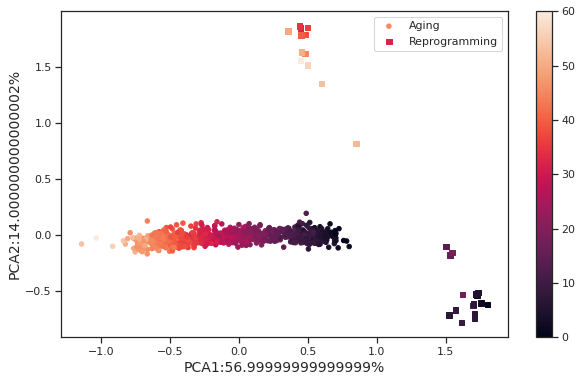

In [121]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=20, label='Aging')
plt.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=30, label='Reprogramming')
plt.xlabel(f'PCA1:{pvar[0]*100}%', fontsize=14)
plt.ylabel(f'PCA2:{pvar[1]*100}%', fontsize=14)
plt.legend()
plt.colorbar()

In [85]:
from umap import UMAP

umap = UMAP(n_neighbors=5)

# Xpa = umap.fit_transform(Xa_clock)
# Xpr = umap.transform(Xr_clock)
umap.fit(Xa_clock.append(Xr_clock))

Xpa = umap.transform(Xa_clock)
Xpr = umap.transform(Xr_clock)

/tmp/ipykernel_26054/1937252164.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  umap.fit(Xa_clock.append(Xr_clock))


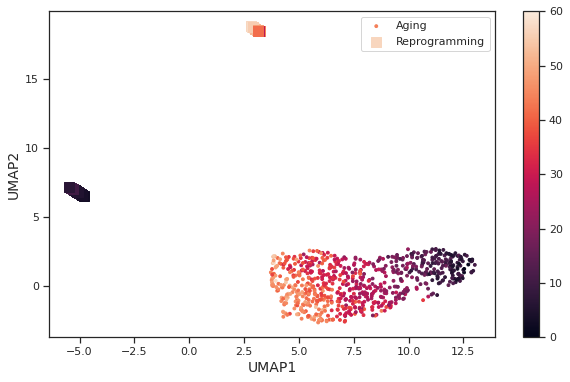

In [86]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=8, label='Aging')
plt.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=100, label='Reprogramming')
plt.xlabel(f'UMAP1', fontsize=14)
plt.ylabel(f'UMAP2', fontsize=14)
plt.legend()
plt.colorbar()

In [122]:
Xa_clock.corrwith(y).sort_values()

cg19283806   -0.869367
cg07082267   -0.846647
cg16054275   -0.835666
cg06874016   -0.833604
cg01528542   -0.823113
                ...   
cg14361627    0.869441
cg24079702    0.885373
cg22454769    0.919675
cg06639320    0.923012
cg16867657    0.946379
Length: 70, dtype: float64

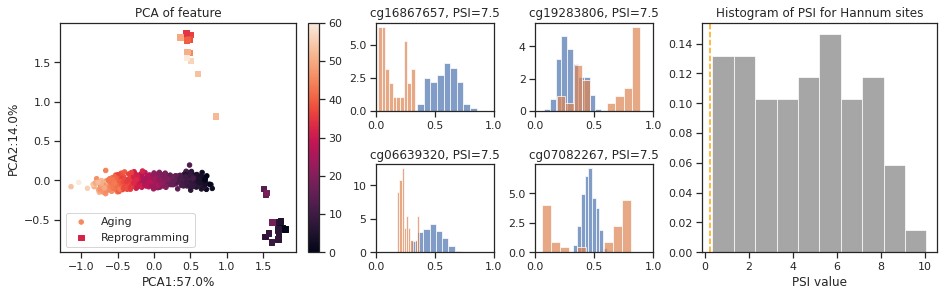

In [172]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(13, 4), constrained_layout=True)
gs = GridSpec(2, 6, figure=fig) 
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 3])
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[1, 3])
ax5 = fig.add_subplot(gs[:, 4:])

# ax0 - PCA
ax0.set_title('PCA of feature')

z1_plot = ax0.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=20, label='Aging')
ax0.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=30, label='Reprogramming')
ax0.set_xlabel(f'PCA1:{round(pvar[0]*100, 2)}%')
ax0.set_ylabel(f'PCA2:{round(pvar[1]*100, 2)}%')
ax0.legend()
plt.colorbar(z1_plot, ax=ax0)


#top from Hannum clocks sites by absolute pearson correlation with age
selected_sites = ['cg16867657', 'cg19283806', 'cg06639320', 'cg07082267']

#examples of sites + PSIs
for k, ax_ in enumerate([ax1, ax2, ax3, ax4]): 
    psi = calculate_psi(np.asarray(Xa_clock[selected_sites[0]])[:, None], 
                        np.asarray(Xr_clock[selected_sites[0]])[:, None]).item()
    ax_.hist(Xa_clock[selected_sites[k]], density=True, alpha=0.7)
    ax_.hist(Xr_clock[selected_sites[k]], density=True, alpha=0.7)
    ax_.set_title(f'{selected_sites[k]}, PSI={round(psi, 1)}')
    ax_.set_xlim([0, 1])


# ax5 - overall PSI hist
psis = calculate_psi(np.array(Xa_clock), np.array(Xr_clock))

ax5.set_title('Histogram of PSI for Hannum sites')
ax5.hist(psis, density=True, alpha=0.7, color='grey')
ax5.axvline(0.2, color='orange', ls='--')
ax5.set_xlabel('PSI value')
plt.show()

# Joint distribution for OOD detection

## Gaussian fit

In [175]:
clock = clocks['coefHannum']
sites = clock.index.intersection(dfr.index)

site = 'cg16867657'

Xa_clock = dfa.loc[[site]].T
Xr_clock = dfr.loc[[site]].T

y = meta['age']
y_rep_day = metr['age'].values

Xa_clock = Xa_clock #- Xa_clock.mean(0)
Xr_clock = Xr_clock #- Xr_clock.mean(0)

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, y, test_size=0.25, random_state=10)

Xy_train = pd.merge(X_train, y_train.to_frame(), left_index=True, right_index=True)
Xy_test = pd.merge(X_test, y_test.to_frame(), left_index=True, right_index=True)

/home/shappiron/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


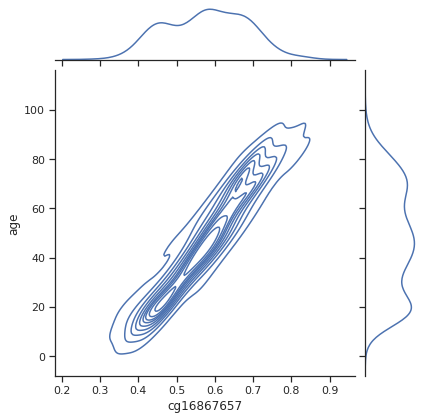

In [25]:
sns.jointplot(X_train.iloc[:, 0], y_train, kind='kde')

In [208]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=1, random_state=0).fit(Xy_train)

/home/shappiron/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


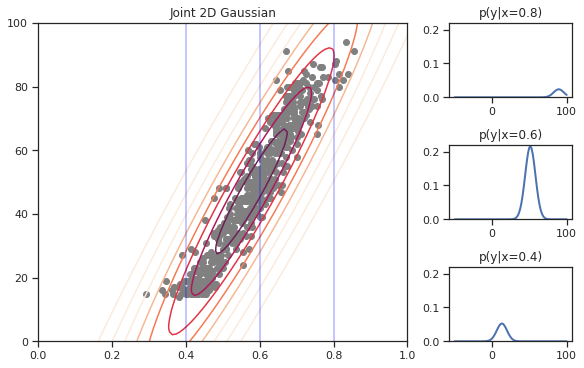

In [209]:
fig = plt.figure(figsize=(8, 5), constrained_layout=True)
gs = GridSpec(3, 4, figure=fig) 

ax0 = fig.add_subplot(gs[:, :3])
ax1 = fig.add_subplot(gs[0, 3])
ax2 = fig.add_subplot(gs[1, 3])
ax3 = fig.add_subplot(gs[2, 3])

# ax0 - Fitted join distribution P(X, y)

from matplotlib.colors import LogNorm
x_gr = np.linspace(0, 1, 100)
y_gr = np.linspace(0, 100, 100)
X_gr, Y_gr = np.meshgrid(x_gr, y_gr)
XX = np.array([X_gr.ravel(), Y_gr.ravel()]).T
Z = (-gm.score_samples(XX)).reshape(X_gr.shape)

ax0.set_title('Joint 2D Gaussian')
# ax0.plot([0., 0.5], [0.2, 0.2], color='red', alpha=0.8) # horizontal line 
# ax0.plot([0.5, 0.5], [0., 0.2], color='red', alpha=0.8) # vertical line 
# ax0.scatter(0.5, 0.2, color='black', zorder=2) # vrejuv dot

ax0.scatter(X_train, y_train, alpha=1.0, color='grey')
CS = ax0.contour(
    X_gr, Y_gr, Z, 
    norm=LogNorm(vmin=1.0, vmax=10.0), 
    levels=np.logspace(0, 1.3, 10),
)

x_slices = [0.8, 0.6, 0.4]
for xk in x_slices:
    ax0.axvline(xk, color='blue', alpha=0.3)

m = 100
y_grid = np.linspace(-50, 100, m)


# y|x cuts 
for k, (xk, ax_) in enumerate(zip(x_slices, [ax1, ax2, ax3])):
    x = np.ones(m) * xk
    xy = np.concatenate([[x], [y_grid]], axis=0).T
    p_y_x = multivariate_normal.pdf(xy, mean=gm.means_.ravel(), cov=gm.covariances_[0])
    ax_.set_title(f'p(y|x={xk})')
    ax_.plot(y_grid, p_y_x, lw=2) 
    ax_.set_ylim([0., 0.22])



## Univariate inference

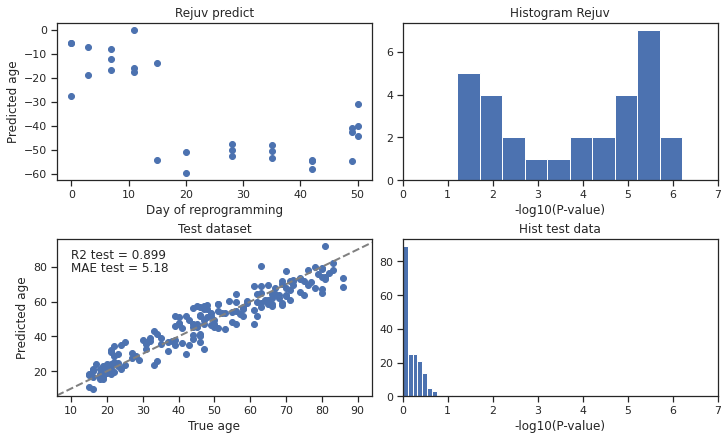

In [223]:
# 4 figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig) 

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

#test on reprogramming the whole pipeline
y_preds = []
xy_pvals = []
for i in range(Xr_clock.shape[0]):
    xrep = Xr_clock.iloc[i, 0]
    yrep, _ = compute_age_univariate(xrep, gm.means_.ravel(), gm.covariances_[0])
    xynew = np.array([xrep, yrep])
    chi2, pval = hotteling_t2_test(xynew, gm.means_.ravel(), gm.covariances_[0])
    y_preds.append(yrep)
    xy_pvals.append(pval)

# ax0 - 
ax0.set_title('Rejuv predict')
ax0.set_xlabel('Day of reprogramming')
ax0.set_ylabel('Predicted age', 
               #fontsize=13, 
               #fontweight='bold', 
               #color='red'
               ) # import red from palette i've send
ax0.scatter(y_rep_day, y_preds)

# ax1 - histogram of log10(p-values) from `hotteling_t2_test`
ax1.set_title('Histogram Rejuv')
ax1.hist(-np.log10(xy_pvals))
ax1.set_xlabel('-log10(P-value)')
ax1.set_xlim([0, 7])


#test on test set
y_preds = []
xy_pvals = []
for i in range(X_test.shape[0]):
    xrep = X_test.iloc[i, 0]
    yrep, _ = compute_age_univariate(xrep, gm.means_.ravel(), gm.covariances_[0])
    xynew = np.array([xrep, yrep])
    chi2, pval = hotteling_t2_test(xynew, gm.means_.ravel(), gm.covariances_[0])
    y_preds.append(yrep)
    xy_pvals.append(pval)


# ax2 - 
ax2.set_title('Test dataset')
ax2.set_ylabel('Predicted Age', 
               #fontsize=13, 
               #fontweight='bold'
               )

ax2.scatter(y_test, y_preds)
ax2.set_xlabel('True age')
ax2.set_ylabel('Predicted age')
ax2.axline([10,10], [90, 90], color='grey', ls='--', lw=2)
ax2.annotate(f'R2 test = {np.round(r2_score(y_test, y_preds), 3)}', xy=[10, 85])
ax2.annotate(f'MAE test = {np.round(mean_absolute_error(y_test, y_preds), 2)}', xy=[10, 77])

# ax3 - 
ax3.set_title('Hist test data')
ax3.hist(-np.log10(xy_pvals))
ax3.set_xlabel('-log10(P-value)')
ax3.set_xlim([0, 7])

plt.show()

## Multivariate inference

In [384]:
# case with dim X > 1
clock = clocks['coefHannum']
sites = clock.index.intersection(dfr.index)

sites_ = ['cg16867657', 'cg06639320']

Xa_clock = dfa.loc[sites_].T
Xr_clock = dfr.loc[sites_].T

y = meta['age']

Xa_clock = Xa_clock #- Xa_clock.mean(0)
Xr_clock = Xr_clock #- Xr_clock.mean(0)

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, y, test_size=0.25, random_state=10)

In [454]:
Xy_train = pd.merge(X_train, y_train.to_frame(), left_index=True, right_index=True)
Xy_test = pd.merge(X_test, y_test.to_frame(), left_index=True, right_index=True)

gm = GaussianMixture(n_components=1, random_state=0).fit(Xy_train)


In [476]:
#test on test set

y_preds = []
xy_pvals = []
for i in range(X_test.shape[0]):
    xrep = np.array(X_test.iloc[i, :])
    yrep, _ = inference_age_multivariate(xrep, gm.means_.ravel(), gm.covariances_[0])
    xynew = np.append(xrep, yrep)
    chi2, pval = hotteling_t2_test(xynew, gm.means_.ravel(), gm.covariances_[0])

    y_preds.append(yrep)
    xy_pvals.append(pval)

print(f'R2 test = {r2_score(y_test, y_preds)}')
print(f'MAE test = {mean_absolute_error(y_test, y_preds)}')
print(f"minimal pvalue = {min(xy_pvals)}")

R2 test = 0.9183437181759181
MAE test = 4.725359760956548
minimal pvalue = 3.402056414358867e-12


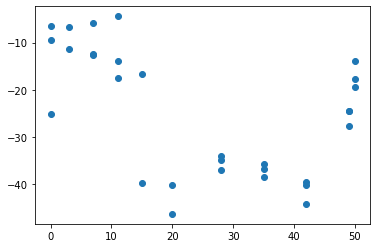

/tmp/ipykernel_9480/3082058164.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(y_rep_day, np.log10(xy_pvals))


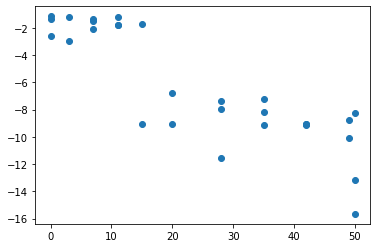

In [484]:
#test on rep set

y_preds = []
xy_pvals = []
for i in range(Xr_clock.shape[0]):
    xrep = np.array(Xr_clock.iloc[i, :])
    yrep, _ = inference_age_multivariate(xrep, gm.means_.ravel(), gm.covariances_[0])
    xynew = np.append(xrep, yrep)
    chi2, pval = hotteling_t2_test(xynew, gm.means_.ravel(), gm.covariances_[0])

    y_preds.append(yrep)
    xy_pvals.append(pval)

plt.scatter(y_rep_day, y_preds)
plt.show()
plt.scatter(y_rep_day, np.log10(xy_pvals))

In [486]:
max(xy_pvals)

0.07121436236583745

# KNN with bootstrap

In [99]:
#knn is more natural here
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

model = KNeighborsRegressor(n_neighbors=10, metric='correlation')
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')

R2 train = 0.9707543099613621
R2 test = 0.9551204807941832
MAE train = 2.6793032786885247
MAE test = 3.37551867219917


Text(0.5, 0, 'reprogramming day')

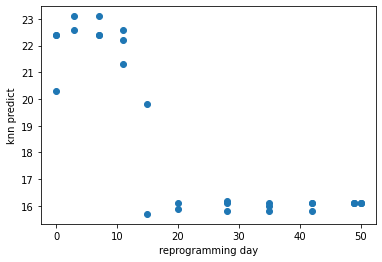

In [100]:
y_rep_predict = model.predict(Xr_clock)
y_rep_day = metr['age'].values

plt.scatter(y_rep_day, y_rep_predict)
plt.ylabel('knn predict')
plt.xlabel('reprogramming day')

In [106]:
#boostrap
n_reps = 100


y_train_pmat = []
y_test_pmat = []
y_rep_pmat = []

for ii in range(n_reps):
    X_train, X_test, y_train, y_test = train_test_split(Xa_clock, y, test_size=0.33, random_state=ii)
    model = KNeighborsRegressor(n_neighbors=10, metric='correlation')
    model.fit(X_train, y_train)

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    y_rep_predict = model.predict(Xr_clock)

    y_train_pmat.append(y_train_predict)
    y_test_pmat.append(y_test_predict)
    y_rep_pmat.append(y_rep_predict)
    
    # print(f'R2 train = {r2_score(y_train, y_train_predict)}')
    # print(f'R2 test = {r2_score(y_test, y_test_predict)}')
    # print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
    # print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')

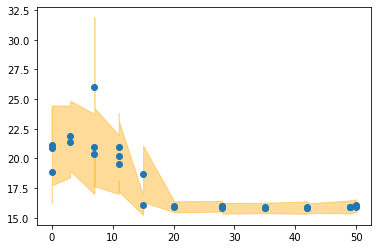

In [107]:
y_rep_pmat = np.asarray(y_rep_pmat)

y_rep_pred_mean = y_rep_pmat.mean(axis=0)
y_rep_pred_std = y_rep_pmat.std(axis=0, ddof=1)

plt.fill_between(y_rep_day, 
                 y_rep_pred_mean - 3*y_rep_pred_std, 
                 y_rep_pred_mean + 3*y_rep_pred_std,
                 alpha=0.4, color='orange')
plt.scatter(y_rep_day, y_rep_pred_mean)

In [108]:
y_rep_day

array([ 0,  0,  0,  3,  3,  7,  7,  7, 11, 11, 11, 15, 15, 20, 20, 28, 28,
       28, 35, 35, 35, 42, 42, 42, 49, 49, 49, 50, 50, 50])

In [109]:
from pymare import meta_regression
cond = (y_rep_day == 11) | (y_rep_day == 15)
y_rep_pred_mean_sample = y_rep_pred_mean[cond]
y_rep_pred_std_sample = y_rep_pred_std[cond]
y_rep_day_sample = y_rep_day[cond]

meta_regression(y_rep_pred_mean_sample, y_rep_pred_std_sample, (y_rep_day_sample == 11).astype(int), 
                X_names=['rej'], 
                add_intercept=False, 
                method='REML').to_df()

,name,estimate,se,z-score,p-value,ci_0.025,ci_0.975
0,rej,20.218251,7.13478,2.833759,0.0046,6.234338,34.202164


In [124]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

model = GaussianProcessRegressor()
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')

R2 train = 0.9999999999999999
R2 test = 0.9452536640386472
MAE train = 1.63979824837132e-07
MAE test = 3.88915123761088


In [125]:
y_rep_std.mean()

0.8404866714815118

In [120]:
_, stds = model.predict(X_test, return_std=True)

stds.mean()

0.0609110404901288

Text(0.5, 0, 'reprogramming day')

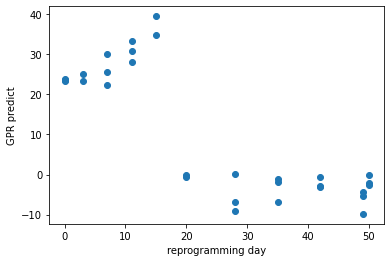

In [126]:
y_rep_predict, y_rep_std = model.predict(Xr_clock, return_std=True)
y_rep_day = metr['age'].values

plt.scatter(y_rep_day, y_rep_predict)
plt.ylabel('GPR predict')
plt.xlabel('reprogramming day')

# Unsorted

<AxesSubplot:>

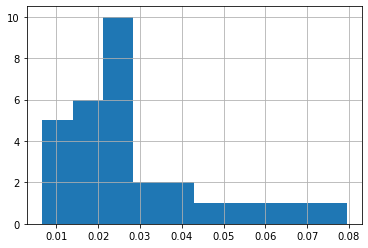

In [23]:
Xr_clock.iloc[:, 20].hist()

In [12]:
#linear model
X_tr = sm.add_constant(X_train)

re = sm.OLS(y_train, X_tr).fit()

print(re.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     245.4
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:15:04   Log-Likelihood:                -1453.8
No. Observations:                 546   AIC:                             3050.
Df Residuals:                     475   BIC:                             3355.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              30.0717     13.123     

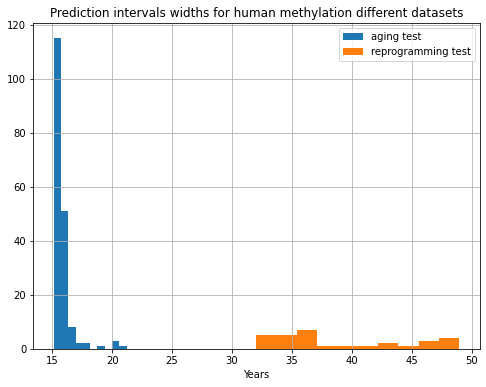

In [22]:
#prediction interval

plt.figure(figsize=(8,6))
y_pred_test = re.get_prediction(sm.add_constant(X_test))
pt = y_pred_test.summary_frame(alpha=0.05)
(pt['obs_ci_upper'] - pt['obs_ci_lower']).hist(label='aging test')

y_pred_test = re.get_prediction(sm.add_constant(Xr_clock))
pt = y_pred_test.summary_frame(alpha=0.05)
(pt['obs_ci_upper'] - pt['obs_ci_lower']).hist(label='reprogramming test')
plt.title('Prediction intervals widths for human methylation different datasets')
plt.xlabel('Years')
plt.legend()
plt.show()


# plt.figure(figsize=(8,6))
# y_pred_test = re.get_prediction(sm.add_constant(Xr_clock))
# pt = y_pred_test.summary_frame(alpha=0.05)

# plt.show()


In [23]:
res = np.empty((pt.shape[0], pt.shape[0]))
for i, (_, sample1) in enumerate(pt.iterrows()):
    for j, (_, sample2) in enumerate(pt.iterrows()):
        m1 = sample1['mean']
        m2 = sample2['mean']
        s1 = sample1['mean_se']
        s2 = sample2['mean_se']
        ss = np.sqrt(s1**2 + s2**2)
        z = (m1 - m2) / ss
        res[i, j] = z

In [24]:
pt

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
GSM1345997,31.590787,11.650446,8.698001,54.483574,7.560245,55.621330
GSM1345998,23.213900,11.825915,-0.023677,46.451478,-1.145334,47.573134
GSM1345999,32.129471,11.898591,8.749088,55.509854,7.633970,56.624973
GSM1346000,33.868215,11.271738,11.719580,56.016850,10.545494,57.190936
GSM1346001,34.376269,11.329541,12.114052,56.638486,10.945657,57.806882
GSM1346002,32.445228,10.563107,11.689031,53.201425,10.440524,54.449932
GSM1346003,39.746753,11.356012,17.432522,62.060984,16.266715,63.226791
GSM1346004,33.494021,11.548467,10.801621,56.186421,9.654300,57.333742
GSM1346005,24.884522,9.727893,5.769497,43.999548,4.420616,45.348429
GSM1346006,39.108300,10.410366,18.652235,59.564365,17.386471,60.830129


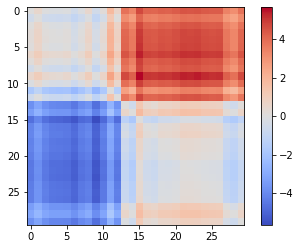

In [26]:
plt.imshow(res, cmap='coolwarm')
plt.colorbar()

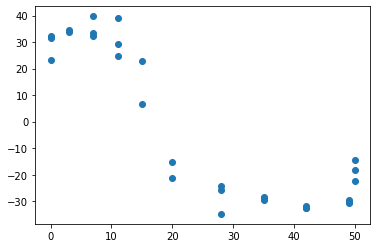

In [27]:
plt.scatter(metr['age'], pt['mean'])

In [190]:
def _psi(expected: np.ndarray, actual: np.ndarray, bucket_type: str = "bins", n_bins: int = 10) -> float:
    """Calculate PSI metric for two arrays.
    
    Parameters
    ----------
        expected : list-like
            Array of expected values
        actual : list-like
            Array of actual values
        bucket_type : str
            Binning strategy. Accepts two options: 'bins' and 'quantiles'. Defaults to 'bins'.
            'bins': input arrays are splitted into bins with equal
                and fixed steps based on 'expected' array
            'quantiles': input arrays are binned according to 'expected' array
                with given number of n_bins
        n_bins : int
            Number of buckets for binning. Defaults to 10.

    Returns
    -------
        A single float number
    """
    breakpoints = np.arange(0, n_bins + 1) / (n_bins) * 100
    if bucket_type == "bins":
        breakpoints = np.histogram(expected, n_bins)[1]
    elif bucket_type == "quantiles":
        breakpoints = np.percentile(expected, breakpoints)

    # Calculate frequencies
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)
    # Clip freaquencies to avoid zero division
    expected_percents = np.clip(expected_percents, a_min=0.0001, a_max=None)
    actual_percents = np.clip(actual_percents, a_min=0.0001, a_max=None)
    # Calculate PSI
    psi_value = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    psi_value = sum(psi_value)

    return psi_value


def calculate_psi(
        expected: np.ndarray, actual: np.ndarray, bucket_type: str = "bins", n_bins: int = 10,
) -> np.ndarray:
    """Apply PSI calculation to 2 1-d or 2-d arrays.

    Parameters
    ----------
    expected : list-like
        Array of expected values
    actual : list-like
        Array of actual values
    bucket_type : str
        Binning strategy. Accepts two options: 'bins' and 'quantiles'. Defaults to 'bins'.
            'bins' - input arrays are splitted into bins with equal
                and fixed steps based on ’expected' array
            'quantiles' - input arrays are binned according to ’expected’ array
                with given number of n_bins
    n_bins : int
        Number of buckets for binning. Defaults to 10.

    Returns
    -------
        np.ndarray
    """
    psi_values = np.empty(expected.shape[1])
    for i in range(0, len(psi_values)):
        psi_values[i] = _psi(expected[:, i], actual[:, i], bucket_type, n_bins)
    return np.array(psi_values)

In [203]:
Xr_clock

,cg20822990,cg22512670,cg25410668,cg04400972,cg16054275,cg09809672,ch.2.30415474F,cg22158769,cg02085953,cg06639320,cg22454769,cg24079702,cg23606718,cg22016779,cg04474832,cg03607117,cg07553761,cg00481951,cg25478614,cg25428494,...,cg19722847,cg18473521,cg01528542,ch.13.39564907R,cg03032497,cg04875128,cg21296230,cg09651136,cg03399905,cg04416734,cg07082267,cg14692377,cg06874016,cg21139312,cg02867102,cg19283806,cg14556683,cg07547549,cg05442902,cg08415592
GSM1345997,0.080881,0.577730,0.434465,0.037554,0.302656,0.741617,0.038847,0.018854,0.208582,0.215053,0.157751,0.129450,0.157162,0.043322,0.197964,0.093701,0.022475,0.112539,0.104148,0.627612,...,0.053351,0.756291,0.505017,0.027634,0.697859,0.029010,0.048549,0.527422,0.120156,0.259444,0.104090,0.027197,0.364749,0.771447,0.052291,0.371827,0.397623,0.349016,0.369909,0.717288
GSM1345998,0.101039,0.517033,0.401794,0.079409,0.319169,0.701487,0.029650,0.027406,0.230460,0.191696,0.132177,0.108579,0.169532,0.087402,0.166705,0.066347,0.019274,0.047905,0.089877,0.615064,...,0.071281,0.722685,0.532078,0.043860,0.757301,0.030111,0.061917,0.453671,0.055161,0.247544,0.090466,0.051730,0.263832,0.843281,0.058615,0.368958,0.285181,0.362935,0.387600,0.655014
GSM1345999,0.071616,0.579778,0.425463,0.025191,0.292542,0.747070,0.036409,0.012961,0.201489,0.246799,0.190674,0.128050,0.151721,0.078160,0.214798,0.099337,0.018846,0.083888,0.114666,0.624458,...,0.068465,0.732573,0.499277,0.029960,0.732272,0.043265,0.049250,0.495546,0.101459,0.307269,0.095484,0.041206,0.368334,0.754109,0.053210,0.350365,0.364302,0.346369,0.349611,0.734795
GSM1346000,0.082970,0.618346,0.399519,0.032981,0.335179,0.721302,0.034507,0.013905,0.258491,0.256664,0.185474,0.134309,0.120391,0.071360,0.203861,0.080781,0.026744,0.084022,0.100608,0.679415,...,0.066175,0.725993,0.589059,0.033918,0.682043,0.036696,0.057786,0.470094,0.089601,0.281716,0.083622,0.044189,0.299325,0.779473,0.057182,0.394334,0.364938,0.421701,0.337356,0.614334
GSM1346001,0.101198,0.727479,0.347107,0.013972,0.339222,0.757150,0.020886,0.007401,0.226375,0.283367,0.198439,0.128032,0.090612,0.081645,0.239522,0.103881,0.040732,0.062824,0.116846,0.690243,...,0.109810,0.733157,0.660200,0.028312,0.666764,0.024858,0.066877,0.415946,0.153820,0.269287,0.057709,0.006595,0.170191,0.747645,0.121935,0.245000,0.302311,0.426454,0.335644,0.601363
GSM1346002,0.093664,0.626425,0.390691,0.025597,0.352957,0.743329,0.142181,0.024863,0.260993,0.269301,0.205105,0.124184,0.116299,0.152109,0.234346,0.074819,0.019152,0.092389,0.130882,0.603698,...,0.079233,0.720995,0.579042,0.103792,0.706690,0.028355,0.086178,0.461070,0.105290,0.257877,0.088254,0.044273,0.288797,0.740386,0.061671,0.412147,0.371678,0.389415,0.312941,0.648258
GSM1346003,0.061473,0.619048,0.442669,0.071429,0.329950,0.704329,0.068245,0.027197,0.225018,0.253291,0.138041,0.080463,0.076817,0.086236,0.213199,0.082562,0.010100,0.026527,0.063131,0.691958,...,0.078672,0.804791,0.424328,0.058462,0.826915,0.088087,0.062294,0.403122,0.066704,0.180356,0.054886,0.032913,0.237872,0.780862,0.033379,0.185251,0.450192,0.384582,0.271577,0.607007
GSM1346004,0.078777,0.577340,0.445015,0.029364,0.340657,0.751446,0.106519,0.020877,0.156278,0.227654,0.204661,0.106467,0.145510,0.120243,0.230973,0.082711,0.015161,0.087629,0.104371,0.619529,...,0.062161,0.765438,0.498860,0.080545,0.702413,0.022549,0.053287,0.450011,0.108560,0.298277,0.087124,0.022348,0.372145,0.770433,0.054834,0.336751,0.372693,0.359893,0.343352,0.679543
GSM1346005,0.092619,0.579632,0.382018,0.033477,0.356295,0.715196,0.175864,0.006008,0.223174,0.234906,0.151400,0.097275,0.110370,0.229654,0.218026,0.078101,0.028100,0.101942,0.174788,0.592242,...,0.091841,0.704304,0.591843,0.142120,0.689254,0.037162,0.088810,0.380432,0.103844,0.325027,0.173493,0.034206,0.344500,0.794774,0.077649,0.402459,0.346461,0.361033,0.258794,0.677555
GSM1346006,0.089938,0.586074,0.508656,0.087384,0.336116,0.713436,0.138937,0.004550,0.231807,0.231567,0.098719,0.071842,0.151778,0.165481,0.223134,0.203091,0.066893,0.04694

In [202]:
calculate_psi(np.array(X_train), np.array(Xr_clock), n_bins=15)

array([1.15284561, 4.38278706, 4.78746481, 7.8337353 , 5.72428539,
       8.30182127, 4.54915578, 0.99198269, 5.63413828, 5.31526762,
       6.11253314, 5.8981152 , 3.43921517, 5.81985134, 6.04097774,
       3.07981957, 7.10544234, 8.6570548 , 6.9055329 , 7.09556379,
       5.75773796, 6.59894414, 5.99553399, 3.32310597, 7.18456288,
       4.14731139, 8.03924101, 5.71603374, 6.86651479, 1.43335913,
       6.52407337, 3.74055806, 2.86772299, 0.91940182, 0.78875623,
       2.3850816 , 7.67455089, 5.02384426, 7.60826705, 0.41680795,
       2.48257051, 6.3200827 , 1.8094129 , 2.62082592, 9.00297607,
       1.90845864, 2.81710967, 1.65570546, 3.9952693 , 7.32100624,
       4.58191451, 4.18880084, 2.66122244, 2.94824144, 6.21734943,
       5.69917831, 5.33257447, 0.70041946, 0.33638476, 3.3223448 ,
       6.05987065, 6.78633473, 2.75086358, 2.30137278, 5.47946556,
       3.41473232, 2.40020273, 4.41825078, 2.28138883, 6.98411821])

In [35]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(loss_function='RMSEWithUncertainty')
model.fit(X_train, y_train)

y_train_unc_predict = model.predict(X_train)
y_test_unc_predict = model.predict(X_test)

y_train_predict = y_train_unc_predict[:, 0]
y_test_predict = y_test_unc_predict[:, 0]
y_train_unc = y_train_unc_predict[:, 1]
y_test_unc = y_test_unc_predict[:, 1]

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')

0:	learn: 4.4243464	total: 13.3ms	remaining: 13.3s
1:	learn: 4.3934299	total: 26ms	remaining: 13s
2:	learn: 4.3625602	total: 36.8ms	remaining: 12.2s
3:	learn: 4.3301936	total: 50.8ms	remaining: 12.6s
4:	learn: 4.2924928	total: 60.1ms	remaining: 12s
5:	learn: 4.2628019	total: 69.7ms	remaining: 11.5s
6:	learn: 4.2335124	total: 80.5ms	remaining: 11.4s
7:	learn: 4.1996208	total: 91.1ms	remaining: 11.3s
8:	learn: 4.1720041	total: 101ms	remaining: 11.1s
9:	learn: 4.1458614	total: 111ms	remaining: 11s
10:	learn: 4.1162405	total: 121ms	remaining: 10.9s
11:	learn: 4.0876699	total: 130ms	remaining: 10.7s
12:	learn: 4.0573019	total: 140ms	remaining: 10.6s
13:	learn: 4.0312693	total: 150ms	remaining: 10.5s
14:	learn: 4.0040088	total: 161ms	remaining: 10.6s
15:	learn: 3.9806753	total: 172ms	remaining: 10.6s
16:	learn: 3.9546486	total: 183ms	remaining: 10.6s
17:	learn: 3.9318192	total: 194ms	remaining: 10.6s
18:	learn: 3.9090426	total: 207ms	remaining: 10.7s
19:	learn: 3.8833878	total: 224ms	remaini

Text(0.5, 0, 'reprogramming day')

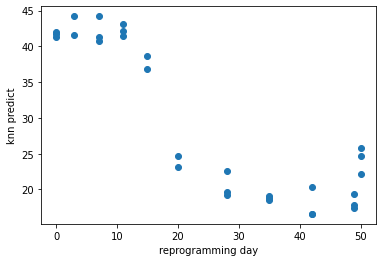

In [36]:
y_rep_unc_predict = model.predict(Xr_clock)
y_rep_predict = y_rep_unc_predict[:, 0]
y_rep_unc = y_rep_unc_predict[:, 1]
y_rep_day = metr['age'].values

plt.scatter(y_rep_day, y_rep_predict)
plt.ylabel('knn predict')
plt.xlabel('reprogramming day')

In [31]:
res = np.empty((pt.shape[0], pt.shape[0]))
for i in range(y_rep_predict.shape[0]):
    for j in range(y_rep_predict.shape[0]):
        m1 = y_rep_unc_predict[i, 0]
        m2 = y_rep_unc_predict[j, 0]
        s1 = y_rep_unc_predict[i, 1]
        s2 = y_rep_unc_predict[j, 1]
        ss = np.sqrt(s1 + s2)
        z = (m1 - m2) / ss
        res[i, j] = z

In [35]:
y_rep_unc_predict

array([[4.12810337e+01, 5.97722529e-01],
       [4.19292739e+01, 5.72115352e-01],
       [4.17557291e+01, 7.02480003e-01],
       [4.15786895e+01, 4.10506198e-01],
       [4.41978164e+01, 4.11051507e-01],
       [4.06958372e+01, 3.07988751e-01],
       [4.41803326e+01, 3.54399013e-01],
       [4.13422951e+01, 5.32087659e-01],
       [4.20776972e+01, 2.83592717e-01],
       [4.14443400e+01, 2.17547849e-01],
       [4.31151176e+01, 4.42885490e-01],
       [3.67884867e+01, 2.27902659e-01],
       [3.86700143e+01, 4.36352932e-01],
       [2.31735173e+01, 6.27369261e-02],
       [2.47325186e+01, 4.97958363e-02],
       [1.96444976e+01, 6.29790228e-02],
       [1.92375112e+01, 5.53792146e-02],
       [2.25499600e+01, 5.39319815e-02],
       [1.88033834e+01, 3.99305393e-02],
       [1.84897316e+01, 3.01829318e-02],
       [1.90411336e+01, 4.77159875e-02],
       [1.65857940e+01, 5.43552674e-02],
       [1.66027101e+01, 3.01993728e-02],
       [2.03076465e+01, 4.78647340e-02],
       [1.741367

/home/shappiron/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


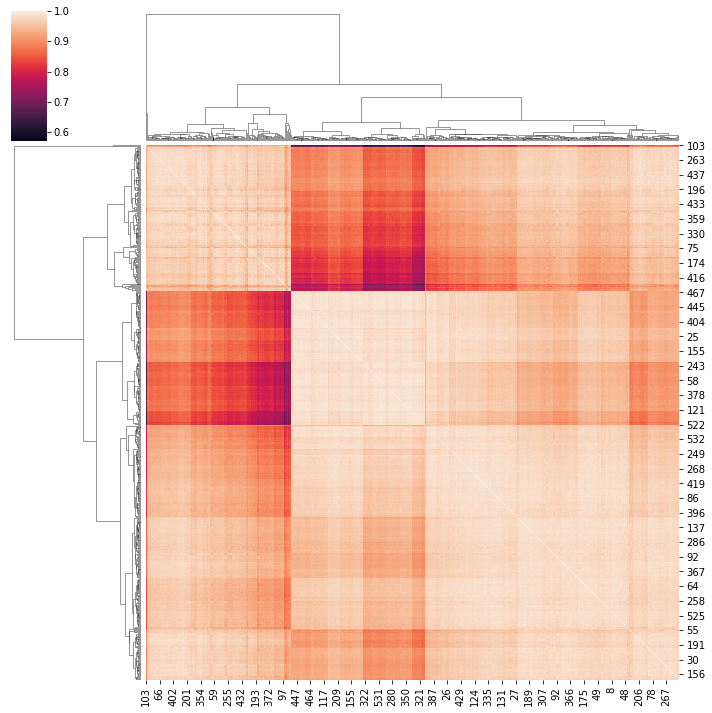

In [214]:
sns.clustermap(np.corrcoef(X_train))

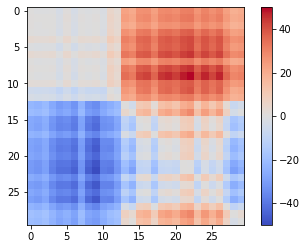

In [33]:
plt.imshow(res, cmap='coolwarm')
plt.colorbar()

In [43]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.2, 
                          loss_function='RMSEWithUncertainty', posterior_sampling=True, 
                          verbose=False, random_seed=0)
model.fit(X_train, y_train, eval_set=(X_test, y_test),)
preds = model.virtual_ensembles_predict(Xr_clock, prediction_type='TotalUncertainty', 
                                        virtual_ensembles_count=10)

mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
knowledge = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data = preds[:,2] # average estimated data uncertainty

In [41]:
res = np.empty((pt.shape[0], pt.shape[0]))
for i in range(y_rep_predict.shape[0]):
    for j in range(y_rep_predict.shape[0]):
        m1 = mean_preds[i]
        m2 = mean_preds[j]
        s1 = data[i]
        s2 = data[j]
        ss = np.sqrt(s1 + s2)
        z = (m1 - m2) / ss
        res[i, j] = z

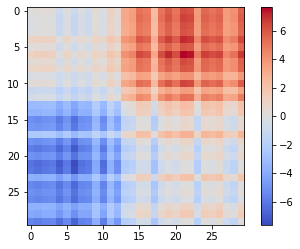

In [49]:
plt.imshow(res, cmap='coolwarm')
plt.colorbar()

In [205]:
#knn is more natural here
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

class ModifiedBayesianRidge(BayesianRidge):

    def predict(self, X):
        y_mean = self._decision_function(X)
        # if  self.normalize:
        # X = (X - self.X_offset_) / self.X_scale_
        aleatoric = 1. / self.alpha_
        epistemic = (np.dot(X, self.sigma_) * X).sum(axis=1)
        return y_mean, aleatoric, epistemic

model = KNeighborsRegressor(n_neighbors=10, metric='euclidean')
# model = ModifiedBayesianRidge()
# model = BayesianRidge()
# model = ARDRegression()
# model = GradientBoostingRegressor(n_estimators=200)
# model = RandomForestRegressor(200)
# model = SVR(kernel='linear')

model.fit(X_train, y_train)

# y_train_predict, _, _ = model.predict(X_train)
# y_test_predict, y_test_predict_ale, y_test_predict_epi = model.predict(X_test)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')

R2 train = 0.9670916391583533
R2 test = 0.9654056451933379
MAE train = 2.8749084249084245
MAE test = 2.8666666666666667


Text(0.5, 0, 'reprogramming day')

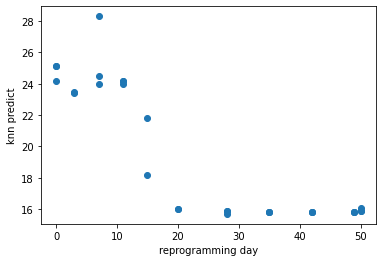

In [207]:
y_rep_predict = model.predict(Xr_clock)
# y_rep_predict, y_rep_ale, y_rep_epi  = model.predict(np.asarray(Xr_clock))
y_rep_day = metr['age'].values

plt.scatter(y_rep_day, y_rep_predict)
plt.ylabel('knn predict')
plt.xlabel('reprogramming day')

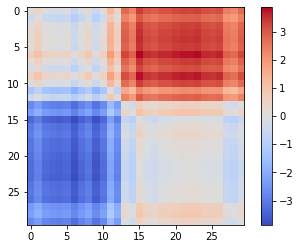

In [153]:
res = np.empty((pt.shape[0], pt.shape[0]))
for i in range(y_rep_predict.shape[0]):
    for j in range(y_rep_predict.shape[0]):
        m1 = y_rep_predict[i]
        m2 = y_rep_predict[j]
        s1 = y_rep_epi[i]
        s2 = y_rep_epi[j]
        ss = np.sqrt(s1 + s2)
        z = (m1 - m2) / ss
        res[i, j] = z

plt.imshow(res, cmap='coolwarm')
plt.colorbar()

In [156]:
y_rep_epi

array([111.7197959 , 116.15368091, 110.50585   , 107.36666547,
       105.56248678, 104.57647185, 113.34449959, 112.41069165,
       100.67265873, 111.05979331, 110.55896928, 113.62102805,
       113.52102566, 181.129802  , 180.73057863, 198.19992794,
       188.5190868 , 171.76122279, 197.20674832, 200.50838492,
       195.85453068, 203.99873488, 206.26058048, 192.49905729,
       208.14203698, 213.25512383, 197.1003932 , 209.97700972,
       217.2300153 , 199.54073492])

In [94]:
x_rep_cond = (y_rep_day < 15).astype(int)

In [157]:
from pymare import meta_regression

meta_regression(y_rep_predict, y_rep_epi, y_rep_day, 
                X_names=['rej'], 
                add_intercept=True, 
                method='REML').to_df()

,name,estimate,se,z-score,p-value,ci_0.025,ci_0.975
0,intercept,31.019710,3.391869,9.145314,0.0,24.371768,37.667651
1,rej,-1.352355,0.128819,-10.498078,0.0,-1.604836,-1.099874


In [71]:
# sub = meta[['averages', 'eAge_coefHannum', 'eAge_coefHorvath', 'age']]

# g = sns.lmplot(x='averages', y='eAge_coefHorvath', data=sub)
# plt.xlabel('Reprogramming average methylation', fontsize=14)
# plt.ylabel('Horvath clocks, predicted eAge', fontsize=14)
# def annotate(data, **kws):
#     from scipy import stats
#     r, p = stats.pearsonr(data['averages'], data['eAge_coefHorvath'])
#     ax = plt.gca()
#     ax.text(.25, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
#             transform=ax.transAxes, fontsize = 14)
    
# g.map_dataframe(annotate)
# plt.show()

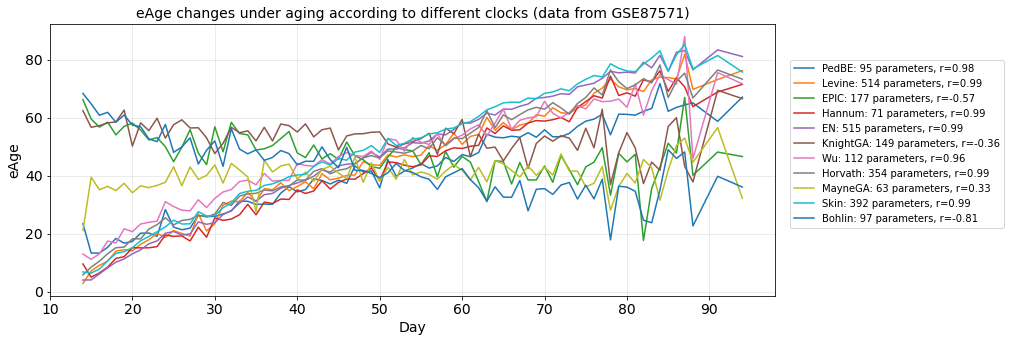

In [70]:
#Aging process
plt.figure(figsize=(13,5))
#plt.scatter(times, ages)
for name in group.columns:
    n_params = len(clocks[name.split('_')[1]].index)
    lbl = name.split('_coef')[1]
    r = np.round(np.corrcoef(group.index.tolist(), group[name])[0, 1], 2)
    plt.plot(group.index.tolist(), group[name], label=f'{lbl}: {n_params} parameters, r={r}' ) # average plot
plt.title('eAge changes under aging according to different clocks (data from GSE87571)', fontsize=14)
plt.xlabel('Day', fontsize=14)
plt.ylabel('eAge', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.grid(alpha=0.3)
plt.legend(loc=(1.02, 0.25))
plt.savefig('figs/clocks_aging.png', dpi=300, bbox_inches='tight')
plt.show()

In [61]:
cname = 'coefHorvath'
clock = clocks[cname]
sites = clock.index.intersection(dfa.index)

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

#scaling?
# Xa_clock = Xa_clock - Xa_clock.mean(0)
# Xr_clock = Xr_clock - Xr_clock.mean(0)

In [62]:
meta['state'] = 'aging' + '_' + meta['age'].astype(str)
metr['state'] = 'rep' + '_' + metr['age'].astype(str)
met_melt = meta.append(metr)

/tmp/ipykernel_7732/3026777716.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met_melt = meta.append(metr)


In [63]:
melt = Xa_clock.sample(5).append(Xr_clock)
lbls = met_melt['state'].loc[melt.index]
melt.index = melt.index + '_' + lbls

/tmp/ipykernel_7732/1793212538.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  melt = Xa_clock.sample(5).append(Xr_clock)


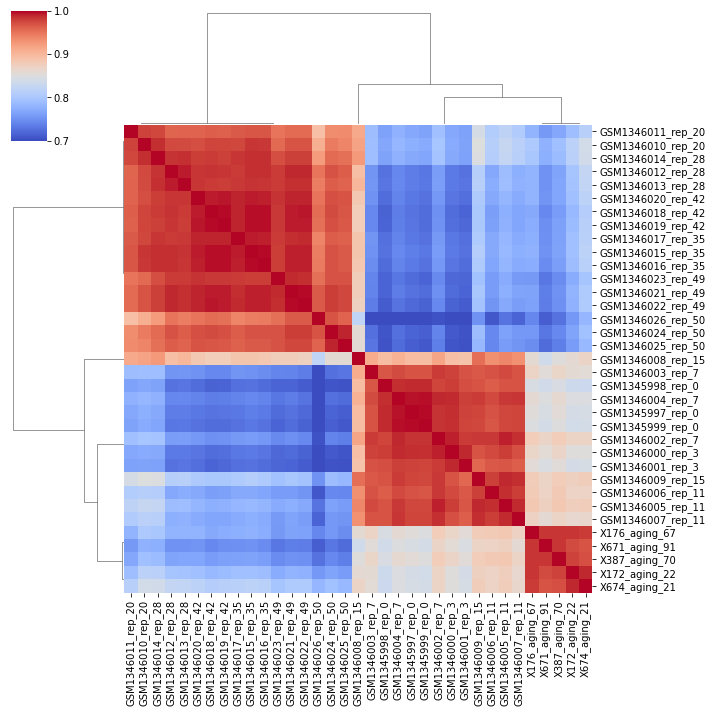

In [65]:
sns.clustermap(melt.T.corr(), metric='correlation', vmax=1, vmin=0.7, cmap='coolwarm', )

In [12]:
#do pca now

pca = PCA(3)

# Assumption: reprogramming is distributed as aging
# Xpa = pca.fit_transform(Xa_clock)
# Xpr = pca.transform(Xr_clock)

# Assumption: reprogramming is something other than aging
pca.fit(Xa_clock.append(Xr_clock))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

/tmp/ipykernel_7097/1674905582.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca.fit(Xa_clock.append(Xr_clock))


In [13]:
pvar = np.round(pca.explained_variance_ratio_, 2)

In [14]:
ya = meta[f'eAge_{cname}']
yr = metr[f'eAge_{cname}']

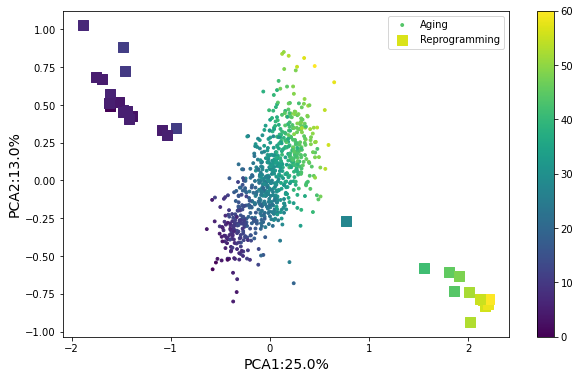

In [15]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=8, label='Aging')
plt.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=100, label='Reprogramming')
plt.xlabel(f'PCA1:{pvar[0]*100}%', fontsize=14)
plt.ylabel(f'PCA2:{pvar[1]*100}%', fontsize=14)
plt.legend()
plt.colorbar()

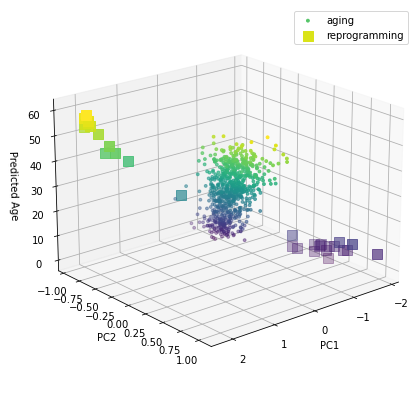

In [24]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(projection='3d')
# ax.scatter(Xpa[:, 0], Xpa[:, 1], Xpa[:, 2], c=ya, s=8)
# ax.scatter(Xpr[:, 0], Xpr[:, 1], Xpr[:, 2], c=yr, marker='s', s=100)
ax.scatter(Xpa[:, 0], Xpa[:, 1], ya, c=ya, s=8, label='aging')
ax.scatter(Xpr[:, 0], Xpr[:, 1], yr, c=yr, marker='s', s=100, label='reprogramming')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Predicted Age')
ax.view_init(20, 50)
ax.legend()

In [99]:
ya.min()

0.0